# 03 - Classificando patologias em toras usando combinação de `LBP + SVM` e normalizando amostras pela dimensão da imagem (quantidade de píxels)

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'normal': 0,
                'broca':1,
                'fissura': 2,
                'musgo': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias_toras.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias_toras.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img:np.ndarray = io.imread(path, as_gray=True)
    
    lbp = local_binary_pattern(image=img, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    # Realizando normalização pela quantidade de píxeis
    arr /= np.product(img.shape)

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/lbp_norm1_toras.csv')
data

normal: 107 amostras
broca: 90 amostras
fissura: 109 amostras
musgo: 111 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,0.062339,0.020684,0.002552,0.015116,0.003219,0.021569,0.002868,0.016283,0.003188,0.009106,...,0.014097,0.004920,0.017840,0.004161,0.013598,0.005019,0.018280,0.074520,0.126319,0
1,0.067556,0.022592,0.003121,0.016275,0.003088,0.023164,0.003025,0.016869,0.002724,0.007599,...,0.014031,0.004255,0.019073,0.004641,0.013473,0.004054,0.019374,0.071963,0.127372,0
2,0.062777,0.025827,0.002639,0.012041,0.003192,0.026918,0.002728,0.012305,0.003084,0.008778,...,0.010976,0.005282,0.022085,0.004384,0.010007,0.004933,0.022278,0.072940,0.126353,0
3,0.066076,0.024677,0.003045,0.014568,0.003464,0.025366,0.002964,0.015250,0.002973,0.008439,...,0.013148,0.004666,0.022506,0.004403,0.013219,0.004442,0.021941,0.076049,0.130858,0
4,0.065848,0.025710,0.002824,0.015218,0.003266,0.026152,0.002895,0.014964,0.003022,0.008147,...,0.013099,0.004046,0.022672,0.003753,0.013573,0.004189,0.022565,0.071876,0.126972,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.055930,0.024259,0.002415,0.011399,0.002808,0.023978,0.002246,0.010332,0.003032,0.011175,...,0.008929,0.003257,0.018812,0.003145,0.009434,0.004268,0.018924,0.065813,0.113938,3
356,0.062714,0.019921,0.002953,0.014799,0.003117,0.019884,0.002825,0.014508,0.002789,0.009222,...,0.014179,0.003882,0.016768,0.003718,0.013833,0.003754,0.016221,0.069585,0.124317,3
357,0.061074,0.022898,0.002437,0.013924,0.002824,0.024058,0.002127,0.012919,0.002553,0.009824,...,0.012841,0.004757,0.018256,0.002940,0.011604,0.004680,0.018721,0.065251,0.120755,3
358,0.062252,0.021824,0.002702,0.013319,0.003248,0.021764,0.002850,0.012610,0.002599,0.010159,...,0.013821,0.004075,0.018457,0.003514,0.012787,0.004504,0.019432,0.070358,0.124533,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 2121
              precision    recall  f1-score   support

      normal       0.89      0.89      0.89        28
       broca       0.93      0.39      0.55        36
     fissura       0.43      0.94      0.59        16
       musgo       0.87      0.93      0.90        28

    accuracy                           0.74       108
   macro avg       0.78      0.79      0.73       108
weighted avg       0.83      0.74      0.73       108



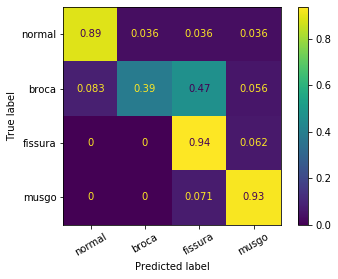

Rodada 1	-	Seed 130
              precision    recall  f1-score   support

      normal       0.81      0.75      0.78        28
       broca       0.71      0.69      0.70        29
     fissura       0.73      0.76      0.75        25
       musgo       0.79      0.85      0.81        26

    accuracy                           0.76       108
   macro avg       0.76      0.76      0.76       108
weighted avg       0.76      0.76      0.76       108



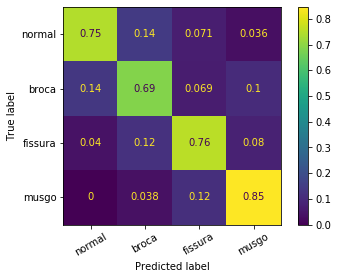

Rodada 2	-	Seed 1560
              precision    recall  f1-score   support

      normal       0.91      0.72      0.81        29
       broca       0.82      0.60      0.69        30
     fissura       0.50      0.83      0.62        23
       musgo       0.84      0.81      0.82        26

    accuracy                           0.73       108
   macro avg       0.77      0.74      0.74       108
weighted avg       0.78      0.73      0.74       108



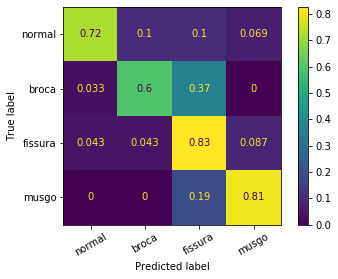

Rodada 3	-	Seed 5815
              precision    recall  f1-score   support

      normal       0.93      0.66      0.77        38
       broca       0.57      0.57      0.57        23
     fissura       0.55      0.90      0.68        20
       musgo       0.96      0.89      0.92        27

    accuracy                           0.74       108
   macro avg       0.75      0.75      0.73       108
weighted avg       0.79      0.74      0.75       108



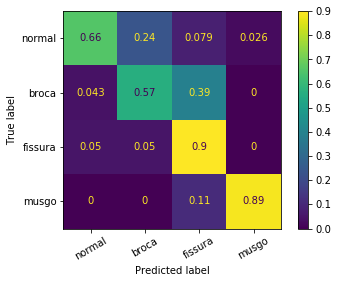

Rodada 4	-	Seed 5288
              precision    recall  f1-score   support

      normal       0.86      0.83      0.85        30
       broca       0.76      0.46      0.58        28
     fissura       0.57      0.74      0.64        23
       musgo       0.78      0.93      0.85        27

    accuracy                           0.74       108
   macro avg       0.74      0.74      0.73       108
weighted avg       0.75      0.74      0.73       108



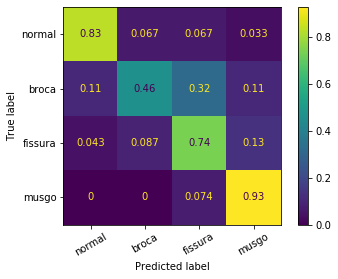

Rodada 5	-	Seed 1280
              precision    recall  f1-score   support

      normal       0.86      0.64      0.73        28
       broca       0.64      0.57      0.60        28
     fissura       0.56      0.76      0.64        25
       musgo       0.86      0.89      0.87        27

    accuracy                           0.71       108
   macro avg       0.73      0.72      0.71       108
weighted avg       0.73      0.71      0.71       108



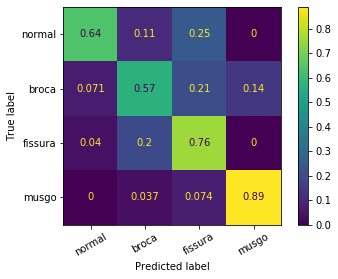

Rodada 6	-	Seed 523
              precision    recall  f1-score   support

      normal       0.90      0.84      0.87        31
       broca       0.72      0.60      0.65        30
     fissura       0.67      0.75      0.71        24
       musgo       0.78      0.91      0.84        23

    accuracy                           0.77       108
   macro avg       0.77      0.78      0.77       108
weighted avg       0.77      0.77      0.77       108



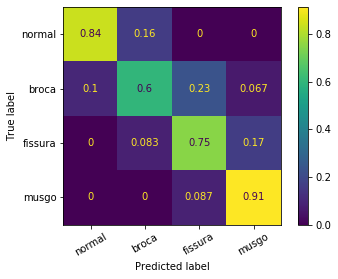

Rodada 7	-	Seed 1149
              precision    recall  f1-score   support

      normal       0.72      0.64      0.68        28
       broca       0.64      0.55      0.59        29
     fissura       0.62      0.84      0.71        25
       musgo       0.83      0.77      0.80        26

    accuracy                           0.69       108
   macro avg       0.70      0.70      0.70       108
weighted avg       0.70      0.69      0.69       108



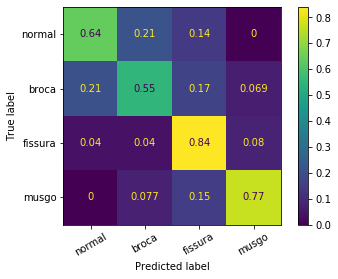

Rodada 8	-	Seed 1421
              precision    recall  f1-score   support

      normal       0.88      0.82      0.85        28
       broca       0.76      0.57      0.65        28
     fissura       0.70      0.91      0.79        23
       musgo       0.87      0.93      0.90        29

    accuracy                           0.81       108
   macro avg       0.80      0.81      0.80       108
weighted avg       0.81      0.81      0.80       108



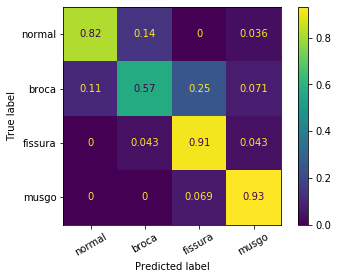

Rodada 9	-	Seed 5457
              precision    recall  f1-score   support

      normal       0.80      0.87      0.83        23
       broca       0.53      0.78      0.63        23
     fissura       0.75      0.53      0.62        34
       musgo       0.88      0.79      0.83        28

    accuracy                           0.72       108
   macro avg       0.74      0.74      0.73       108
weighted avg       0.75      0.72      0.72       108



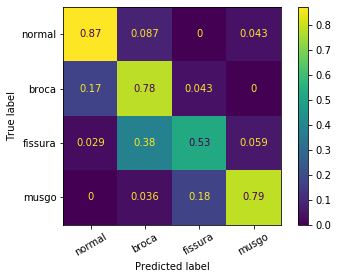

Rodada 10	-	Seed 5499
              precision    recall  f1-score   support

      normal       0.88      0.92      0.90        25
       broca       0.67      0.36      0.47        33
     fissura       0.50      0.73      0.59        26
       musgo       0.77      0.83      0.80        24

    accuracy                           0.69       108
   macro avg       0.71      0.71      0.69       108
weighted avg       0.70      0.69      0.67       108



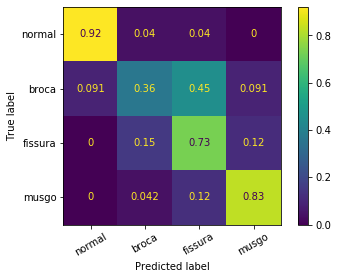

Rodada 11	-	Seed 2719
              precision    recall  f1-score   support

      normal       0.80      0.71      0.75        28
       broca       0.75      0.50      0.60        30
     fissura       0.53      0.79      0.63        24
       musgo       0.85      0.88      0.87        26

    accuracy                           0.71       108
   macro avg       0.73      0.72      0.71       108
weighted avg       0.74      0.71      0.71       108



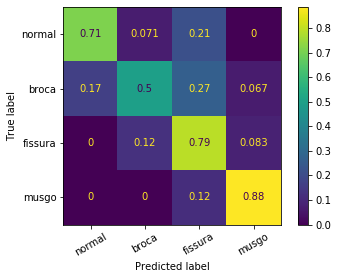

Rodada 12	-	Seed 5097
              precision    recall  f1-score   support

      normal       0.80      0.80      0.80        30
       broca       0.76      0.57      0.65        28
     fissura       0.70      0.82      0.75        28
       musgo       0.79      0.86      0.83        22

    accuracy                           0.76       108
   macro avg       0.76      0.76      0.76       108
weighted avg       0.76      0.76      0.76       108



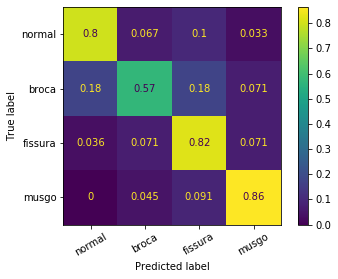

Rodada 13	-	Seed 1403
              precision    recall  f1-score   support

      normal       0.83      0.73      0.78        26
       broca       0.64      0.59      0.62        27
     fissura       0.70      0.78      0.74        27
       musgo       0.87      0.93      0.90        28

    accuracy                           0.76       108
   macro avg       0.76      0.76      0.76       108
weighted avg       0.76      0.76      0.76       108



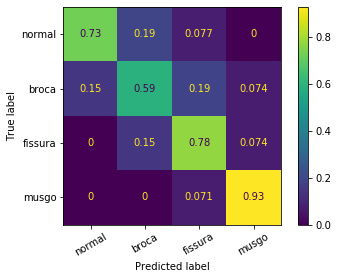

Rodada 14	-	Seed 5894
              precision    recall  f1-score   support

      normal       0.89      0.81      0.85        31
       broca       0.47      0.64      0.54        22
     fissura       0.79      0.61      0.69        31
       musgo       0.85      0.92      0.88        24

    accuracy                           0.74       108
   macro avg       0.75      0.74      0.74       108
weighted avg       0.77      0.74      0.75       108



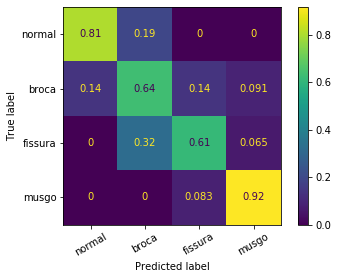

Rodada 15	-	Seed 5980
              precision    recall  f1-score   support

      normal       0.92      0.86      0.89        28
       broca       0.70      0.64      0.67        25
     fissura       0.69      0.83      0.75        24
       musgo       0.93      0.90      0.92        31

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.81       108
weighted avg       0.82      0.81      0.82       108



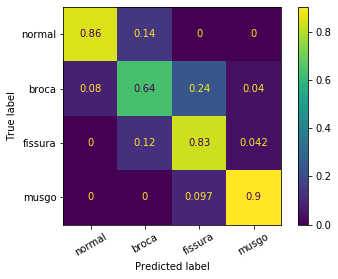

Rodada 16	-	Seed 5218
              precision    recall  f1-score   support

      normal       0.91      0.91      0.91        34
       broca       0.68      0.59      0.63        22
     fissura       0.62      0.82      0.71        22
       musgo       1.00      0.87      0.93        30

    accuracy                           0.81       108
   macro avg       0.80      0.80      0.80       108
weighted avg       0.83      0.81      0.82       108



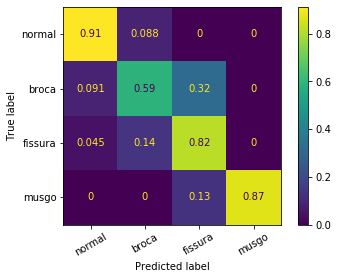

Rodada 17	-	Seed 1995
              precision    recall  f1-score   support

      normal       0.83      0.89      0.86        28
       broca       0.70      0.45      0.55        31
     fissura       0.55      0.68      0.61        25
       musgo       0.85      0.96      0.90        24

    accuracy                           0.73       108
   macro avg       0.73      0.75      0.73       108
weighted avg       0.73      0.73      0.72       108



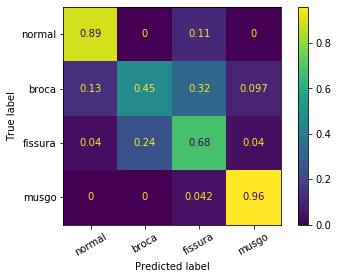

Rodada 18	-	Seed 7957
              precision    recall  f1-score   support

      normal       0.94      0.88      0.91        33
       broca       0.72      0.67      0.69        27
     fissura       0.54      0.78      0.64        18
       musgo       0.96      0.83      0.89        30

    accuracy                           0.80       108
   macro avg       0.79      0.79      0.78       108
weighted avg       0.82      0.80      0.80       108



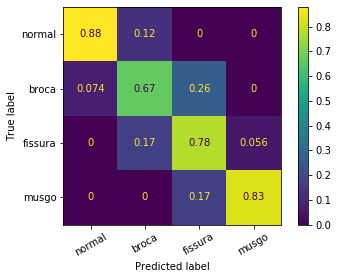

Rodada 19	-	Seed 5208
              precision    recall  f1-score   support

      normal       0.81      0.88      0.85        25
       broca       0.58      0.62      0.60        24
     fissura       0.88      0.67      0.76        33
       musgo       0.87      1.00      0.93        26

    accuracy                           0.79       108
   macro avg       0.78      0.79      0.78       108
weighted avg       0.79      0.79      0.78       108



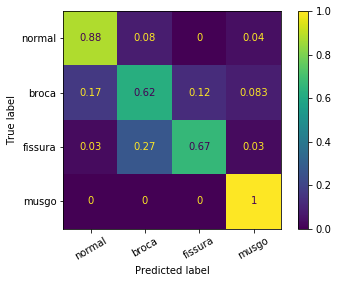

Rodada 20	-	Seed 5568
              precision    recall  f1-score   support

      normal       0.69      0.92      0.79        24
       broca       0.72      0.46      0.57        28
     fissura       0.62      0.72      0.67        29
       musgo       0.88      0.78      0.82        27

    accuracy                           0.71       108
   macro avg       0.73      0.72      0.71       108
weighted avg       0.72      0.71      0.71       108



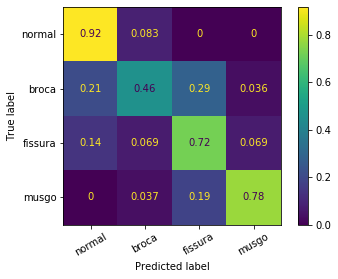

Rodada 21	-	Seed 3053
              precision    recall  f1-score   support

      normal       0.90      0.86      0.88        21
       broca       0.52      0.71      0.60        21
     fissura       0.69      0.64      0.67        28
       musgo       0.97      0.84      0.90        38

    accuracy                           0.77       108
   macro avg       0.77      0.76      0.76       108
weighted avg       0.80      0.77      0.78       108



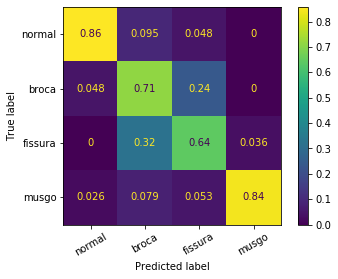

Rodada 22	-	Seed 7184
              precision    recall  f1-score   support

      normal       0.88      0.72      0.79        29
       broca       0.71      0.55      0.62        31
     fissura       0.54      0.88      0.67        24
       musgo       0.90      0.79      0.84        24

    accuracy                           0.72       108
   macro avg       0.76      0.73      0.73       108
weighted avg       0.76      0.72      0.73       108



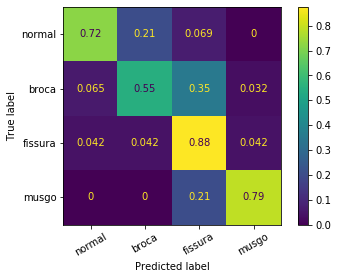

Rodada 23	-	Seed 7635
              precision    recall  f1-score   support

      normal       0.88      0.72      0.79        29
       broca       0.64      0.76      0.70        21
     fissura       0.81      0.87      0.84        30
       musgo       0.93      0.89      0.91        28

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.81       108
weighted avg       0.83      0.81      0.82       108



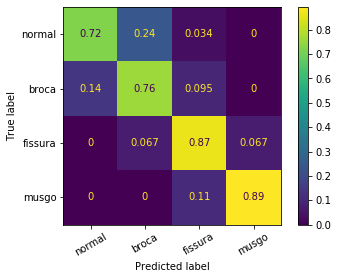

Rodada 24	-	Seed 2626
              precision    recall  f1-score   support

      normal       0.85      0.74      0.79        31
       broca       0.56      0.60      0.58        25
     fissura       0.68      0.68      0.68        28
       musgo       0.85      0.92      0.88        24

    accuracy                           0.73       108
   macro avg       0.73      0.73      0.73       108
weighted avg       0.74      0.73      0.73       108



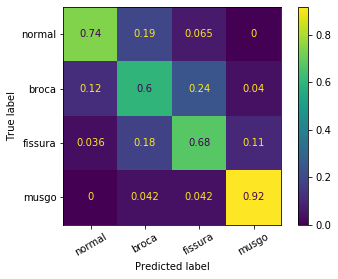

Rodada 25	-	Seed 3326
              precision    recall  f1-score   support

      normal       0.75      0.83      0.79        29
       broca       0.80      0.44      0.57        27
     fissura       0.68      0.70      0.69        27
       musgo       0.76      1.00      0.86        25

    accuracy                           0.74       108
   macro avg       0.75      0.74      0.73       108
weighted avg       0.75      0.74      0.73       108



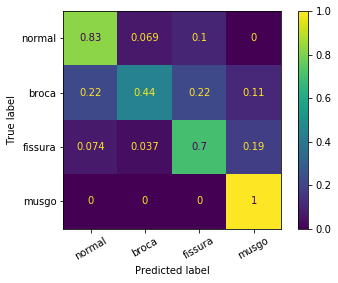

Rodada 26	-	Seed 1510
              precision    recall  f1-score   support

      normal       0.77      0.77      0.77        22
       broca       0.54      0.91      0.68        22
     fissura       0.83      0.42      0.56        36
       musgo       0.84      0.93      0.88        28

    accuracy                           0.72       108
   macro avg       0.75      0.76      0.72       108
weighted avg       0.76      0.72      0.71       108



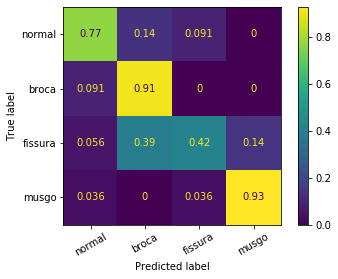

Rodada 27	-	Seed 6831
              precision    recall  f1-score   support

      normal       0.77      0.87      0.82        23
       broca       0.74      0.45      0.56        31
     fissura       0.58      0.78      0.67        27
       musgo       0.93      0.93      0.93        27

    accuracy                           0.74       108
   macro avg       0.75      0.76      0.74       108
weighted avg       0.75      0.74      0.73       108



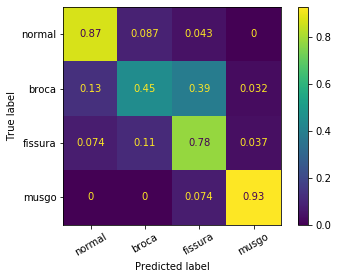

Rodada 28	-	Seed 1984
              precision    recall  f1-score   support

      normal       0.85      0.81      0.83        27
       broca       0.71      0.58      0.64        26
     fissura       0.64      0.78      0.70        27
       musgo       0.89      0.89      0.89        28

    accuracy                           0.77       108
   macro avg       0.77      0.77      0.77       108
weighted avg       0.77      0.77      0.77       108



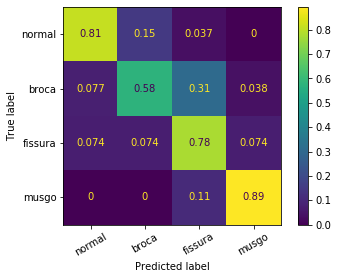

Rodada 29	-	Seed 7867
              precision    recall  f1-score   support

      normal       0.89      0.75      0.81        32
       broca       0.72      0.64      0.68        28
     fissura       0.57      0.77      0.65        22
       musgo       0.92      0.92      0.92        26

    accuracy                           0.77       108
   macro avg       0.77      0.77      0.77       108
weighted avg       0.79      0.77      0.77       108



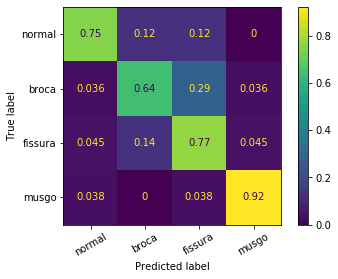

In [4]:
df = pd.read_csv('./csvs/lbp_norm1_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

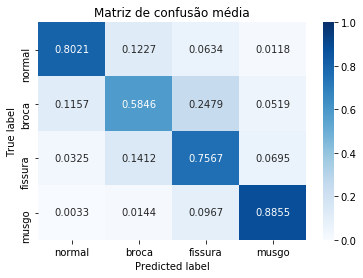

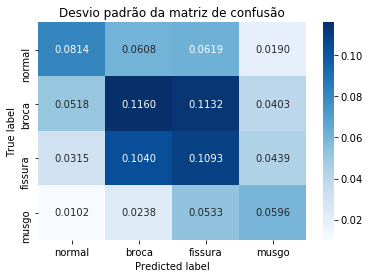

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia  f1-normal   f1-broca  f1-fissura   f1-musgo
count  30.000000  30.000000  30.000000   30.000000  30.000000
mean    0.750309   0.820568   0.614139    0.680264   0.874422
std     0.035278   0.055234   0.056268    0.063579   0.040419
min     0.685185   0.679245   0.470588    0.555556   0.800000
25%     0.724537   0.786007   0.572802    0.637650   0.841111
50%     0.740741   0.814943   0.609579    0.672619   0.880678
75%     0.768519   0.859515   0.654174    0.710369   0.901823
max     0.814815   0.911765   0.701754    0.838710   0.928571


Acurácia,f1-normal,f1-broca,f1-fissura,f1-musgo
0.740741,0.892857,0.549020,0.588235,0.896552
0.759259,0.777778,0.701754,0.745098,0.814815
0.731481,0.807692,0.692308,0.622951,0.823529
0.740741,0.769231,0.565217,0.679245,0.923077
0.740741,0.847458,0.577778,0.641509,0.847458
0.712963,0.734694,0.603774,0.644068,0.872727
0.768519,0.866667,0.654545,0.705882,0.840000
0.694444,0.679245,0.592593,0.711864,0.800000
0.805556,0.851852,0.653061,0.792453,0.900000
0.722222,0.833333,0.631579,0.620690,0.830189


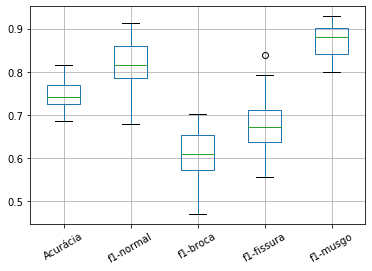

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')